# **Art Style Classification : Transfer Learning With EfficientNet-B0**
Thi Kim Khanh Le

MB/CSE604

Machine Learning Fundamental

# I. EfficientNet-B0 Architecture Overview

EfficientNet-B0 is the baseline and smallest model in the EfficientNet family, a set of convolutional neural networks (CNNs) known for their high efficiency and performance. Created by Google AI, the EfficientNet family was developed to balance accuracy and computational cost by systematically scaling the network's depth, width, and image resolution.

**The EfficientNet-B0 network consists of:**
1. ***Stem***

- Initial layer with a standard convolution followed by a batch normalization and a ReLU6 activation.
- Convolution with 32 filters, kernel size 3x3, stride 2.
2. ***Body***
- Consists of a series of MBConv blocks with different configurations.
- Each block includes depthwise separable convolutions and squeeze-and-excitation layers.
- Example configuration for MBConv block:
    - Expansion ratio: The factor by which the input channels are expanded.
    - Kernel size: Size of the convolutional filter.
    - Stride: The stride length for convolution.
    - SE ratio: Ratio for squeeze-and-excitation.
3. ***Head***
- Includes a final convolutional block, followed by a global average pooling layer.
- A fully connected layer with a softmax activation function for classification.

More on EfficientNet-B0's architecture: https://www.geeksforgeeks.org/computer-vision/efficientnet-architecture/


# II. Why Transfer Learning for Art Style Classification?

Art style classification presents a significant challenge, even for human experts with art history training. While traditional approaches rely on both visual characteristics within the artwork and the historical and cultural context surrounding its creation, such as artist identity and historical period, this project focuses exclusively on visual characteristics: line, color, composition, techinique and brushwork, texture.

**The Challenge**

1. ***High intra-class variation***: Impressionist paintings range from Monet's soft landscapes to Degas' dynamic figures
2. ***Low inter-class separation***: Realism and Romanticism both use naturalistic rendering;Expressionism and Fauvism both employ bold colors
3. ***Class imbalance***: Dataset of  about 43,000 images with class sizes ranging from 336 to 2,100 training samples

### Why Transfer Learning with EfficientNetB0?
**Feature Reusability:** Low-level features (edges, textures, colors) learned on ImageNet's 1.2M images transfer effectively to art analysis, providing a foundation without art-specific pre-training.

**Two-Stage Training:**

- ***Stage 1 (Feature Extraction)***: Frozen base model, train only classification head.
- ***Stage 2 (Fine-Tuning)***: Unfreeze last 50 layers, apply dynamic data augmentation (random flips, rotations, zooms) to prevent memorization and learn style-invariant patterns.


**Benefits of two-stage transfer learning**
- Improved performance: It often leads to better accuracy than training a model from scratch, especially when the target dataset is small.
- Faster training: The initial stage of training only the final layers is much faster than training the entire model. The second stage requires less computation time because the model is already partially trained.
- Reduces overfitting: Freezing the backbone initially prevents the model from overfitting to the smaller target dataset too early.


This approach achieves human non-expert level performance while requiring only hours of training, demonstrating that deep learning can learn abstract artistic concepts from visual data alone.

# III. Library Imports


In [ ]:
# ======================================
# System & Utility Imports
# ======================================
import os                 # File and directory operations
import random             # Random sampling and shuffling
import shutil             # Copying and moving files
from math import floor    # Mathematical floor operation
from pathlib import Path  # Object-oriented filesystem paths
from tqdm import tqdm     # Progress bars for loops

# ======================================
# TensorFlow / Keras Imports
# ======================================
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers, models, regularizers
from tensorflow.keras.applications import EfficientNetB0  # Pretrained CNN model
from tensorflow.keras.callbacks import (
    EarlyStopping,          # Stop training early when no improvement
    ReduceLROnPlateau,      # Reduce learning rate when validation stalls
    ModelCheckpoint         # Save best model weights during training
)

# ======================================
# Data Analysis & Visualization
# ======================================
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# ======================================
# Scikit-learn Metrics & Utilities
# ======================================
from sklearn.metrics import (
    precision_recall_fscore_support,  # Compute precision, recall, F1-score
    classification_report,            # Text summary of model performance
    confusion_matrix,                 # Evaluate prediction errors by class
    roc_curve, auc, roc_auc_score     # For ROC-AUC evaluation
)
from sklearn.preprocessing import label_binarize  # Convert labels for ROC curves
from collections import Counter                   # Count class occurrences


# IV. Dataset

##Download dataset
Download dataset steubk/wikiart from kaggle

In [ ]:

# Install kagglehub
!pip install -q kagglehub

from kagglehub import dataset_download

# Download WikiArt dataset
path = dataset_download("steubk/wikiart")
print("Dataset downloaded to:", path)

Using Colab cache for faster access to the 'wikiart' dataset.
Dataset downloaded to: /kaggle/input/wikiart


## Count images in each art style directory
The ***steubk/wikiart*** dataset is a large collection containing a total of 81,444 images. Let's take a look at the dataset and see the distribution of styles

In [ ]:

data_dir = path  # path returned above

# Count images in each art style directory
counts = {}
for style in os.listdir(data_dir):
    style_path = os.path.join(data_dir, style)
    if os.path.isdir(style_path):
        n_images = len([f for f in os.listdir(style_path)
                        if f.lower().endswith(('.jpg', '.jpeg', '.png'))])
        counts[style] = n_images

# Sort by count (descending)
counts = dict(sorted(counts.items(), key=lambda x: x[1], reverse=True))

# Print summary
total = sum(counts.values())
print(f"Total images: {total}")
for style, cnt in counts.items():
    print(f"{style:30s}: {cnt:5d} ({cnt/total:.2%})")


Total images: 81444
Impressionism                 : 13060 (16.04%)
Realism                       : 10733 (13.18%)
Romanticism                   :  7019 (8.62%)
Expressionism                 :  6736 (8.27%)
Post_Impressionism            :  6450 (7.92%)
Symbolism                     :  4528 (5.56%)
Art_Nouveau_Modern            :  4334 (5.32%)
Baroque                       :  4240 (5.21%)
Abstract_Expressionism        :  2782 (3.42%)
Northern_Renaissance          :  2552 (3.13%)
Naive_Art_Primitivism         :  2405 (2.95%)
Cubism                        :  2235 (2.74%)
Rococo                        :  2089 (2.56%)
Color_Field_Painting          :  1615 (1.98%)
Pop_Art                       :  1483 (1.82%)
Early_Renaissance             :  1391 (1.71%)
High_Renaissance              :  1343 (1.65%)
Minimalism                    :  1337 (1.64%)
Mannerism_Late_Renaissance    :  1279 (1.57%)
Ukiyo_e                       :  1167 (1.43%)
Fauvism                       :   934 (1.15%)
Pointillism 

**Dataset Overview**

- Total images: 81,444

- Classes (Art Styles): 26

- Largest class: Impressionism → 13,060 images (16.04%)

- Smallest class: Action_painting → 98 images (0.12%)

→ So the dataset covers a broad range of art movements, from classical (Baroque, Renaissance) to modern (Cubism, Pop Art, Minimalism).

**Class Imbalance**

- The class distribution is highly imbalanced:

- Impressionism has approximately 130 times more samples than Action_painting.

- The top 5 classes already make up about 54% of the entire dataset.

This imbalance will strongly affect training if not handled carefully, the model might just learn to predict the majority styles.

## Create dataset for training
###Data Balancing Approach:

As we can see from above, the s***teubk/wikiart dataset***  is quite large but has an imbalanced distribution of data among its categories. To handle this imbalance, I will:
  - remove four categories that have insufficient data for training (Action_painting, Analytical_Cubism, Synthetic_Cubism, New_Realism), and
  - set 3,000 as the maximum number of images for each category.

This way, our CNN model won’t overfit to the larger classes, and the chosen maximum number of 3000 images for each category should still be sufficient for effective training.

After that, I will split my dataset into train /validation /test sets and copy everything into a clean, new directory with organized subfolders.


###Code Explanation

***1. Setup parameters***

- random.seed(42) for reproducibility.

- Defines input (src_dir), output (out_dir), max images per class (cap = 3000), and classes to drop (drop = {...}).

- Sets the data split ratios (70% train, 20% val, 10% test).

***2. Prepare output directory***

- Delete the old output folder and creates a new one.

***3. Process each art style***

- Lists all style folders except the dropped ones.

- For each style:

    - Collect all image files (.jpg, .jpeg, .png).

    - Randomly selects up to 3,000 images (random.sample).

    - Split them into train/val/test subsets using the defined ratios.

    - Create corresponding subfolders inside /train, /val, and /test.

    - Copy the selected images into those folders.

***4. Summarize results***

- Record the number of original and used images for each style, and how many went into each split.

In [ ]:

random.seed(42)

src_dir = path
out_dir = "/content/wikiart_capped"
cap = 3000
drop = {"Action_painting", "Analytical_Cubism", "Synthetic_Cubism", "New_Realism"}
train_ratio = 0.7
val_ratio = 0.2
test_ratio = 0.1

# Remove existing output directory if it exists
if os.path.exists(out_dir):
    shutil.rmtree(out_dir)

os.makedirs(out_dir, exist_ok=True)

# Gather style folders
styles = [d for d in os.listdir(src_dir) if os.path.isdir(os.path.join(src_dir, d))]
styles = [s for s in styles if s not in drop]

summary = []
for style in tqdm(sorted(styles), desc="Processing styles"):
    style_src = os.path.join(src_dir, style)
    imgs = [f for f in os.listdir(style_src) if f.lower().endswith(('.jpg', '.jpeg', '.png'))]
    n = len(imgs)
    n_take = min(n, cap)
    sampled = random.sample(imgs, n_take)

    # Calculate split sizes
    n_train = int(floor(train_ratio * n_take))
    n_val = int(floor(val_ratio * n_take))
    n_test = n_take - n_train - n_val

    train_imgs = sampled[:n_train]
    val_imgs = sampled[n_train:n_train + n_val]
    test_imgs = sampled[n_train + n_val:]

    # Create class subfolders
    train_folder = os.path.join(out_dir, "train", style)
    val_folder = os.path.join(out_dir, "val", style)
    test_folder = os.path.join(out_dir, "test", style)
    os.makedirs(train_folder, exist_ok=True)
    os.makedirs(val_folder, exist_ok=True)
    os.makedirs(test_folder, exist_ok=True)

    # Copy images
    for fname in train_imgs:
        shutil.copy2(os.path.join(style_src, fname), os.path.join(train_folder, fname))
    for fname in val_imgs:
        shutil.copy2(os.path.join(style_src, fname), os.path.join(val_folder, fname))
    for fname in test_imgs:
        shutil.copy2(os.path.join(style_src, fname), os.path.join(test_folder, fname))

    summary.append((style, n, n_take, len(train_imgs), len(val_imgs), len(test_imgs)))

# Print summary
print("\nStyle, OrigCount, Taken, Train, Val, Test")
total_taken = 0
for row in summary:
    print(f"{row[0]:30s}: {row[1]:5d} -> {row[2]:5d} (train {row[3]}, val {row[4]}, test {row[5]})")
    total_taken += row[2]

Processing styles: 100%|██████████| 23/23 [01:02<00:00,  2.70s/it]


Style, OrigCount, Taken, Train, Val, Test
Abstract_Expressionism        :  2782 ->  2782 (train 1947, val 556, test 279)
Art_Nouveau_Modern            :  4334 ->  3000 (train 2100, val 600, test 300)
Baroque                       :  4240 ->  3000 (train 2100, val 600, test 300)
Color_Field_Painting          :  1615 ->  1615 (train 1130, val 323, test 162)
Contemporary_Realism          :   481 ->   481 (train 336, val 96, test 49)
Cubism                        :  2235 ->  2235 (train 1564, val 447, test 224)
Early_Renaissance             :  1391 ->  1391 (train 973, val 278, test 140)
Expressionism                 :  6736 ->  3000 (train 2100, val 600, test 300)
Fauvism                       :   934 ->   934 (train 653, val 186, test 95)
High_Renaissance              :  1343 ->  1343 (train 940, val 268, test 135)
Impressionism                 : 13060 ->  3000 (train 2100, val 600, test 300)
Mannerism_Late_Renaissance    :  1279 ->  1279 (train 895, val 255, test 129)
Minimalism       

## Visualize WikiArt Dataset Distribution After Balancing for Train/Validation/Test

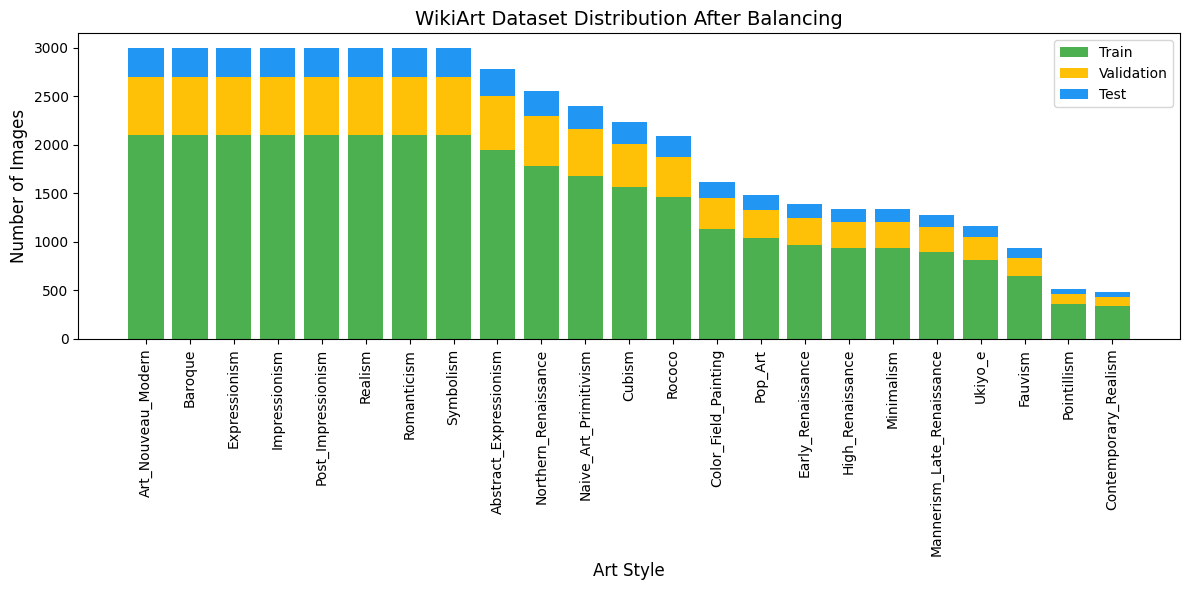

In [ ]:
# Extract data from summary
summary_sorted = sorted(summary, key=lambda x: x[2], reverse=True)
styles = [row[0] for row in summary_sorted]
train_counts = [row[3] for row in summary_sorted]
val_counts = [row[4] for row in summary_sorted]
test_counts = [row[5] for row in summary_sorted]

# Compute stacked positions
x = np.arange(len(styles))

# Create stacked bar chart
plt.figure(figsize=(12, 6))
plt.bar(x, train_counts, label='Train', color='#4CAF50')
plt.bar(x, val_counts, bottom=train_counts, label='Validation', color='#FFC107')
plt.bar(x, test_counts, bottom=np.array(train_counts) + np.array(val_counts),
        label='Test', color='#2196F3')

# Labels and styling
plt.title("WikiArt Dataset Distribution After Balancing", fontsize=14)
plt.xlabel("Art Style", fontsize=12)
plt.ylabel("Number of Images", fontsize=12)
plt.xticks(x, styles, rotation=90)
plt.legend()
plt.tight_layout()
plt.show()

The dataset is still imbalanced but it is way less imbalanced like in the beginning, because the extremely overrepresented classes (Impressionism with 13,060 images, Realism with 10,733 images) have been capped at 3,000, preventing them from dominating the training process. Without capping, these classes would account for 30% of all training data, but now they represent a more reasonable proportion.

## Load Datasets

This block loads and organizes images from the WikiArt dataset into TensorFlow datasets for training, validation, and testing — ready to feed into a model

In [ ]:

batch_size = 32                                       # Each training step processes 32 images at a time (for memory efficiency and gradient stability)

train_ds = tf.keras.utils.image_dataset_from_directory(
    directory="/content/wikiart_capped/train",        # Loads all training images from the given folder
    image_size=(224, 224),                            # Each image is resized to 224×224 pixels
    batch_size=batch_size,                            # Images are batched into groups of 32
    seed=42,                                          # Randomizes the order each epoch (important for training)
    shuffle=True,                                     # Shuffles the data before each epoch
    label_mode='categorical'                          # means labels are one-hot encoded vectors (e.g., [0,0,1,0,...])
)

val_ds = tf.keras.utils.image_dataset_from_directory(
    directory="/content/wikiart_capped/val",
    image_size=(224, 224),
    batch_size=batch_size,
    seed=42,
    shuffle=False,
    label_mode='categorical'
)

test_ds = tf.keras.utils.image_dataset_from_directory(
    directory="/content/wikiart_capped/test",
    image_size=(224, 224),
    batch_size=batch_size,
    seed=42,
    shuffle=False,
    label_mode='categorical'
)

class_names = train_ds.class_names
print(f"\nFound {len(class_names)} classes")
print(f"Classes: {class_names}")

Found 33317 files belonging to 23 classes.
Found 9515 files belonging to 23 classes.
Found 4774 files belonging to 23 classes.

Found 23 classes
Classes: ['Abstract_Expressionism', 'Art_Nouveau_Modern', 'Baroque', 'Color_Field_Painting', 'Contemporary_Realism', 'Cubism', 'Early_Renaissance', 'Expressionism', 'Fauvism', 'High_Renaissance', 'Impressionism', 'Mannerism_Late_Renaissance', 'Minimalism', 'Naive_Art_Primitivism', 'Northern_Renaissance', 'Pointillism', 'Pop_Art', 'Post_Impressionism', 'Realism', 'Rococo', 'Romanticism', 'Symbolism', 'Ukiyo_e']


## Visualize Sample Images

In [ ]:

# Get sample for visualization
images_vis, labels_vis = next(iter(train_ds.take(11)))

plt.figure(figsize=(12, 12))
for i in range(min(9, len(images_vis))):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(images_vis[i].numpy().astype("uint8"))
    plt.title(class_names[labels_vis[i].numpy().argmax()], fontsize=10)
    plt.axis("off")
plt.tight_layout()
plt.show()

Output hidden; open in https://colab.research.google.com to view.

# V. Training/Validation/Test Loss & Accuracy

## Stage 1: Feature Extraction
In this stage, the EfficientNetB0 model pre-trained on ImageNet is used as a fixed feature extractor. By setting ***base_model.trainable = False,*** all the layers in EfficientNetB0 are frozen, meaning their weights will not be updated during training. This allows the model to use the general visual features (such as edges, textures, and shapes) it already learned from ImageNet.

Only the last layer (Dense layers) is trainable. This layer learns to map the extracted features to the specific art style categories.

This approach makes training faster and reduces the risk of overfitting, since we’re only training a small number of parameters while reusing powerful pre-trained representations.

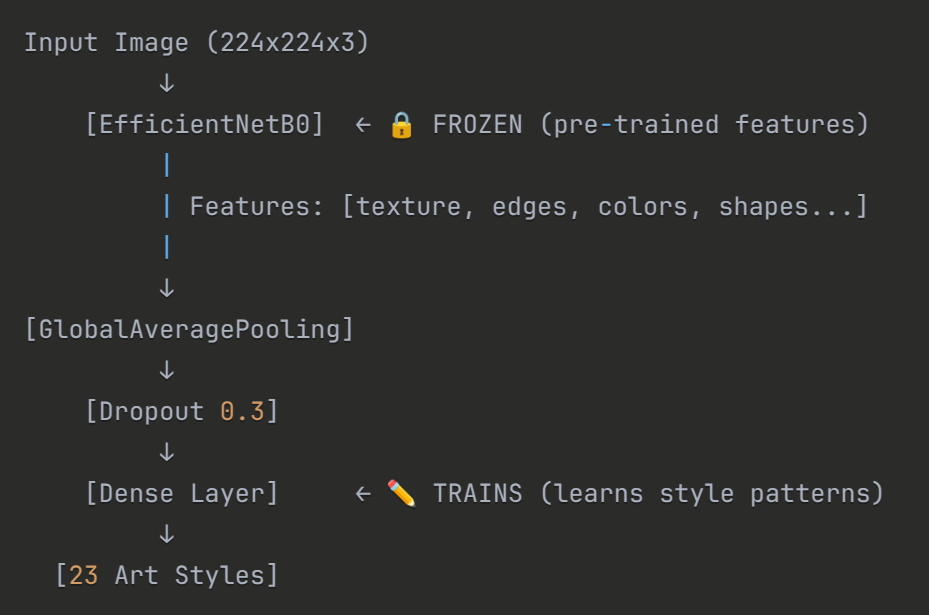

1. **Apply EfficientNet preprocessing**

EfficientNet expects specific normalization that matches its ImageNet training so I am using EfficientNet's own preprocessing (preprocess_input) instead of manual Rescaling

- ***def preprocess (images, labels)***: This function prepares input images for EfficientNetB0 by:

    - Scaling and normalizing pixel values in the way EfficientNet expects.

    - Returning the same labels unchanged.

- Apply this preprocessing to all my datasets:

    - ***.map(preprocess)*** applies your preprocessing function to every batch of images.

    - ***.prefetch(tf.data.AUTOTUNE)*** makes data loading asynchronous — speeding up training by overlapping data preparation and model execution.

2. **Build model**
- ***base_model = EfficientNetB0(...)*** : This line initializes an EfficientNetB0 model, a pre-trained convolutional neural network known for its efficiency and accuracy.
    - ***include_top = False*** : This argument specifies that the top classification layers of the original EfficientNetB0 model (which are designed for ImageNet's 1000 classes) should not be included. This allows for adapting the model to a different number of classes.
    - ***weights = 'imagenet'*** : This loads the pre-trained weights from the ImageNet dataset, which enables the model to leverage the learned features from a large and diverse image dataset.
    - ***input_shape = (224, 224, 3)*** : This defines the expected input shape for the images, which is 224 pixels in height and width, and 3 channels for RGB color.
- ***base_model.trainable = False*** : This crucial line freezes the weights of the base_model. This means that during training, the weights of the pre-trained EfficientNetB0 will not be updated. This is done to preserve the powerful features learned from ImageNet and prevent them from being corrupted by potentially limited or different target domain data.
- ***model = models.Sequential([...])***: This creates a Sequential model, which is a linear stack of layers.

    - ***base_model:*** The pre-trained and frozen EfficientNetB0 model is added as the first layer. It acts as a feature extractor.
    - ***layers.GlobalAveragePooling2D()***: This layer takes the output feature maps from the base_model and computes the average value for each feature map, effectively reducing the spatial dimensions to 1x1. This helps in reducing the number of parameters and preventing overfitting.
    - ***layers.Dropout(0.3)***: This layer introduces dropout regularization, randomly setting 30% of the input units to zero during training.
    - ***layers.Dense(len(class_names), activation='softmax')***: This is the final output layer.
    - ***len(class_names)***: This defines the number of neurons in the dense layer, corresponding to the number of classes in the target dataset.
    - ***activation = 'softmax'***: The softmax activation function is used for multi-class classification, outputting a probability distribution over the classes.

In [ ]:

# Apply EfficientNet preprocessing (no augmentation for stage 1)
def preprocess(images, labels):
    images = tf.keras.applications.efficientnet.preprocess_input(images)
    return images, labels

train_ds_stage1 = train_ds.map(preprocess).prefetch(tf.data.AUTOTUNE)
val_ds_stage1 = val_ds.map(preprocess).prefetch(tf.data.AUTOTUNE)
test_ds_processed = test_ds.map(preprocess).prefetch(tf.data.AUTOTUNE)

# Build model
base_model = EfficientNetB0(
    include_top=False,
    weights='imagenet',
    input_shape=(224, 224, 3)
)
base_model.trainable = False

model = models.Sequential([
    base_model,
    layers.GlobalAveragePooling2D(),
    layers.Dropout(0.3),
    layers.Dense(len(class_names), activation='softmax')
])



### Model Architecture
Looking at EfficientNetB0's architecture: In Stage 1, I freeze 4,049,571 base model parameters and train only the 29,463 parameters in the Dense classification layer

In [ ]:
print("\nModel Architecture:")
model.summary()



Model Architecture:


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ efficientnetb0 (Functional)     │ (None, 7, 7, 1280)     │     4,049,571 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d        │ (None, 1280)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 1280)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 23)             │        29,463 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 4,079,034 (15.56 MB)

 Trainable params: 29,463 (115.09 KB)

 Non-trainable params: 4,049,571 (15.45 MB)

In [ ]:
from tensorflow.keras.utils import plot_model
plot_model(model, to_file="efficientnetb0.png", show_shapes=True, expand_nested=True)


Output hidden; open in https://colab.research.google.com to view.

### Stage 1 Training
1. **model.compile() parameters:**
    - optimizer=Adam(learning_rate=0.001) :
    Uses the Adam optimizer, which adapts the learning rate during training for faster convergence and stable updates.
    The learning_rate=0.001 controls how big each weight update step is.

    - loss='categorical_crossentropy': The loss function for multi-class classification when labels are one-hot encoded.
    It measures how far the model’s predicted probabilities are from the true class labels.

    - metrics=['accuracy']: Tracks how often the model’s predictions match the correct class during training and validation.

2. **model.fit() training setup:**

    - train_ds_stage1 : the training dataset (preprocessed images and labels).

    - validation_data=val_ds_stage1 : dataset used to monitor validation performance after each epoch.

    - epochs=15 : number of full passes over the training data.

    - verbose=1 : shows progress for each epoch.

    The model is trained with the EfficientNetB0 base frozen (feature extractor mode).

In [ ]:
model.compile(
    optimizer=keras.optimizers.Adam(learning_rate=0.001),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)


# Train Stage 1
print("\nTraining Stage 1 (Frozen base)...")
history1 = model.fit(
    train_ds_stage1,
    validation_data=val_ds_stage1,
    epochs=15,
    verbose=1
)

print(f"\n Stage 1 Results:")
print(f"   Train Accuracy: {history1.history['accuracy'][-1]:.3f}")
print(f"   Val Accuracy: {history1.history['val_accuracy'][-1]:.3f}")


Training Stage 1 (Frozen base)...
Epoch 1/15
1042/1042 ━━━━━━━━━━━━━━━━━━━━ 153s 112ms/step - accuracy: 0.2998 - loss: 2.2655 - val_accuracy: 0.4412 - val_loss: 1.7469
Epoch 2/15
1042/1042 ━━━━━━━━━━━━━━━━━━━━ 67s 64ms/step - accuracy: 0.4411 - loss: 1.7306 - val_accuracy: 0.4591 - val_loss: 1.6748
Epoch 3/15
1042/1042 ━━━━━━━━━━━━━━━━━━━━ 66s 64ms/step - accuracy: 0.4680 - loss: 1.6436 - val_accuracy: 0.4666 - val_loss: 1.6387
Epoch 4/15
1042/1042 ━━━━━━━━━━━━━━━━━━━━ 66s 64ms/step - accuracy: 0.4801 - loss: 1.6068 - val_accuracy: 0.4783 - val_loss: 1.6212
Epoch 5/15
1042/1042 ━━━━━━━━━━━━━━━━━━━━ 66s 64ms/step - accuracy: 0.4865 - loss: 1.5786 - val_accuracy: 0.4792 - val_loss: 1.6085
Epoch 6/15
1042/1042 ━━━━━━━━━━━━━━━━━━━━ 66s 64ms/step - accuracy: 0.4884 - loss: 1.5708 - val_accuracy: 0.4797 - val_loss: 1.6100
Epoch 7/15
1042/1042 ━━━━━━━━━━━━━━━━━━━━ 66s 64ms/step - accuracy: 0.4935 - loss: 1.5527 - val_accuracy: 0.4820 - val_loss: 1.5929
Epoch 8/15
1042/1042 ━━━━━━━━━━━━━━━━━━

###Stage 1 Results Interpretation

After training only the new classification layers with the EfficientNetB0 base frozen, the model achieved:

Training accuracy: 50.2%

Validation accuracy: 48.4%

These results are expected at this stage because the pre-trained EfficientNetB0 acts only as a fixed feature extractor, and only the final Dense layer was trained. The model has started learning to map general visual features to art styles, but hasn’t yet adapted the pre-trained features to this specific dataset.

## Stage 2: Finetune with Augmentation
In Stage 2, I will ***unfreeze the last 50 layers of EfficientNetB0*** and train from where Stage 1 left off. In this stage, there will be 2,556,327 trainable parameters, whereas in Stage 1, there were only 29,463 trainable parameters. Using only about 43,000 images with such a large parameter count can lead to overfitting. To avoid this, I use ***data augmentation with random transformations applied during each epoch***, meaning no epoch will see the same augmented images. The model thus sees different augmented versions of the training data. This method effectively creates infinite training variations and thereby prevents overfitting.

**Code Explanation**

1. Data Augmentation (less aggressive):
Randomly flips, rotates, zooms, translates, and adjusts contrast/brightness to make training images more diverse while keeping realism.
Applied only to training data, not validation data.

2. Preprocessing:
Uses EfficientNet’s built-in normalization (preprocess_input) so image pixel ranges match what the pre-trained model expects.

3. Dataset Setup:
Creates ***train_ds_stage2*** and ***val_ds_stage2***  pipelines with augmentation and efficient prefetching.

4. Unfreeze Top Layers for Fine-Tuning

    - Sets ***base_model.trainable = True*** so layers can update.

    - Keeps early EfficientNet layers frozen (generic features).

    - Unfreezes only the last 50 layers to adapt higher-level features for art style recognition.

5. Recompile Without Rebuilding

    - Keeps all Stage 1 weights intact (both base and classifier).

    - Uses a smaller learning rate (0.00008) for gentle fine-tuning.

    - Uses categorical cross-entropy and accuracy metrics.

6. Callbacks for Stable Training

    - EarlyStopping: This callback stops training when the validation accuracy has stopped improving for a specified number of epochs.

    - ReduceLROnPlateau: This callback reduces the learning rate when validation accuracy stops improving for a few epochs, helping the model fine-tune better.

    - ModelCheckpoint: saves the best model automatically.

In [ ]:
# Define optimized data augmentation (slightly less aggressive)
data_augmentation = keras.Sequential([
    layers.RandomFlip("horizontal"),
    layers.RandomRotation(0.12),      # Slightly reduced
    layers.RandomZoom(0.12),          # Slightly reduced
    layers.RandomTranslation(0.08, 0.08),  # Slightly reduced
    layers.RandomContrast(0.08),      # Slightly reduced
    layers.RandomBrightness(0.08),    # Added brightness
], name='data_augmentation')

# Apply augmentation to training data only
def preprocess_train(images, labels):
    images = data_augmentation(images, training=True)
    images = tf.keras.applications.efficientnet.preprocess_input(images)
    return images, labels

def preprocess_val(images, labels):
    images = tf.keras.applications.efficientnet.preprocess_input(images)
    return images, labels

# Reload datasets with proper preprocessing
train_ds_stage2 = train_ds.map(preprocess_train).prefetch(tf.data.AUTOTUNE)
val_ds_stage2 = val_ds.map(preprocess_val).prefetch(tf.data.AUTOTUNE)

# Unfreeze the base model (keep existing architecture - no rebuild!)
base_model.trainable = True

# Freeze early layers, unfreeze last 50 layers
trainable_count = 0
for layer in base_model.layers[:-50]:
    layer.trainable = False

for layer in base_model.layers[-50:]:
    if layer.trainable:
        trainable_count += 1

print(f"\nUnfreezing last 50 layers ({trainable_count} trainable layers)")
print(f"Total trainable params: {sum([tf.size(w).numpy() for w in model.trainable_weights]):,}")

# Recompile model with lower learning rate (NO rebuild - preserves Stage 1 weights)
model.compile(
    optimizer=keras.optimizers.Adam(learning_rate=0.00008),  # Lower LR for fine-tuning
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

print("\nModel will continue training from Stage 1 weights")
print("Architecture unchanged - all learned weights preserved!")


# --- Early Stopping ---

early_stop = EarlyStopping(
    monitor='val_accuracy',      # Metric to monitor (validation accuracy)
    patience=8,                  # Number of epochs to wait for improvement before stopping
    restore_best_weights=True,   # Revert to the model weights from the best epoch
    mode='max',                  # We're looking to maximize validation accuracy
    verbose=1                    # Print a message when stopping occurs
)

# --- Reduce Learning Rate on Plateau ---

reduce_lr = ReduceLROnPlateau(
    monitor='val_accuracy',      # Metric to watch for improvement
    factor=0.5,                  # Reduce learning rate by half when triggered
    patience=4,                  # Wait 4 epochs without improvement before reducing LR
    mode='max',                  # Higher validation accuracy is better
    min_lr=1e-7,                 # Set a lower limit for learning rate
    verbose=1                    # Print updates when learning rate changes
)

# Model checkpoint to save best model
checkpoint = ModelCheckpoint(
    '/content/best_model.keras',
    monitor='val_accuracy',
    save_best_only=True,
    mode='max',
    verbose=1
)




Unfreezing last 50 layers (50 trainable layers)
Total trainable params: 2,556,327

Model will continue training from Stage 1 weights
Architecture unchanged - all learned weights preserved!


### Stage 2 Training

In [ ]:
# Train Stage 2 with more epochs
print("\nTraining Stage 2 (Fine-tuning with augmentation)...")
print("Starting from Stage 1 final state:")
print(f"  Train Accuracy: {history1.history['accuracy'][-1]:.3f}")
print(f"  Val Accuracy: {history1.history['val_accuracy'][-1]:.3f}")
print()

history2 = model.fit(
    train_ds_stage2,
    validation_data=val_ds_stage2,
    epochs=50,                 # Increased epochs
    callbacks=[early_stop, reduce_lr, checkpoint],
    verbose=1
)

print(f"\n Stage 2 Results:")
print(f"   Train Accuracy: {history2.history['accuracy'][-1]:.3f}")
print(f"   Val Accuracy: {history2.history['val_accuracy'][-1]:.3f}")

# Load best model
print("\nLoading best model from checkpoint...")
model = keras.models.load_model('/content/best_model.keras')
print(" Best model loaded successfully")


Training Stage 2 (Fine-tuning with augmentation)...
Starting from Stage 1 final state:
  Train Accuracy: 0.502
  Val Accuracy: 0.484

Epoch 1/50
1042/1042 ━━━━━━━━━━━━━━━━━━━━ 0s 535ms/step - accuracy: 0.3356 - loss: 2.1445
Epoch 1: val_accuracy improved from -inf to 0.48187, saving model to /content/best_model.keras
1042/1042 ━━━━━━━━━━━━━━━━━━━━ 620s 561ms/step - accuracy: 0.3356 - loss: 2.1443 - val_accuracy: 0.4819 - val_loss: 1.5967 - learning_rate: 8.0000e-05
Epoch 2/50
1042/1042 ━━━━━━━━━━━━━━━━━━━━ 0s 518ms/step - accuracy: 0.4614 - loss: 1.6472
Epoch 2: val_accuracy improved from 0.48187 to 0.50699, saving model to /content/best_model.keras
1042/1042 ━━━━━━━━━━━━━━━━━━━━ 556s 533ms/step - accuracy: 0.4614 - loss: 1.6471 - val_accuracy: 0.5070 - val_loss: 1.5194 - learning_rate: 8.0000e-05
Epoch 3/50
1042/1042 ━━━━━━━━━━━━━━━━━━━━ 0s 519ms/step - accuracy: 0.5022 - loss: 1.5188
Epoch 3: val_accuracy improved from 0.50699 to 0.51393, saving model to /content/best_model.keras
10

##Evaluate on Test Set

In [ ]:
test_loss, test_acc = model.evaluate(test_ds_processed, verbose=1)
print(f"\n Final Test Results:")
print(f"   Test Loss: {test_loss:.4f}")
print(f"   Test Accuracy: {test_acc:.4f}")

150/150 ━━━━━━━━━━━━━━━━━━━━ 7s 50ms/step - accuracy: 0.5716 - loss: 1.6685

 Final Test Results:
   Test Loss: 1.7149
   Test Accuracy: 0.5547


## Plot Training/Validation/Testing History


--- Training Dynamics Analysis ---


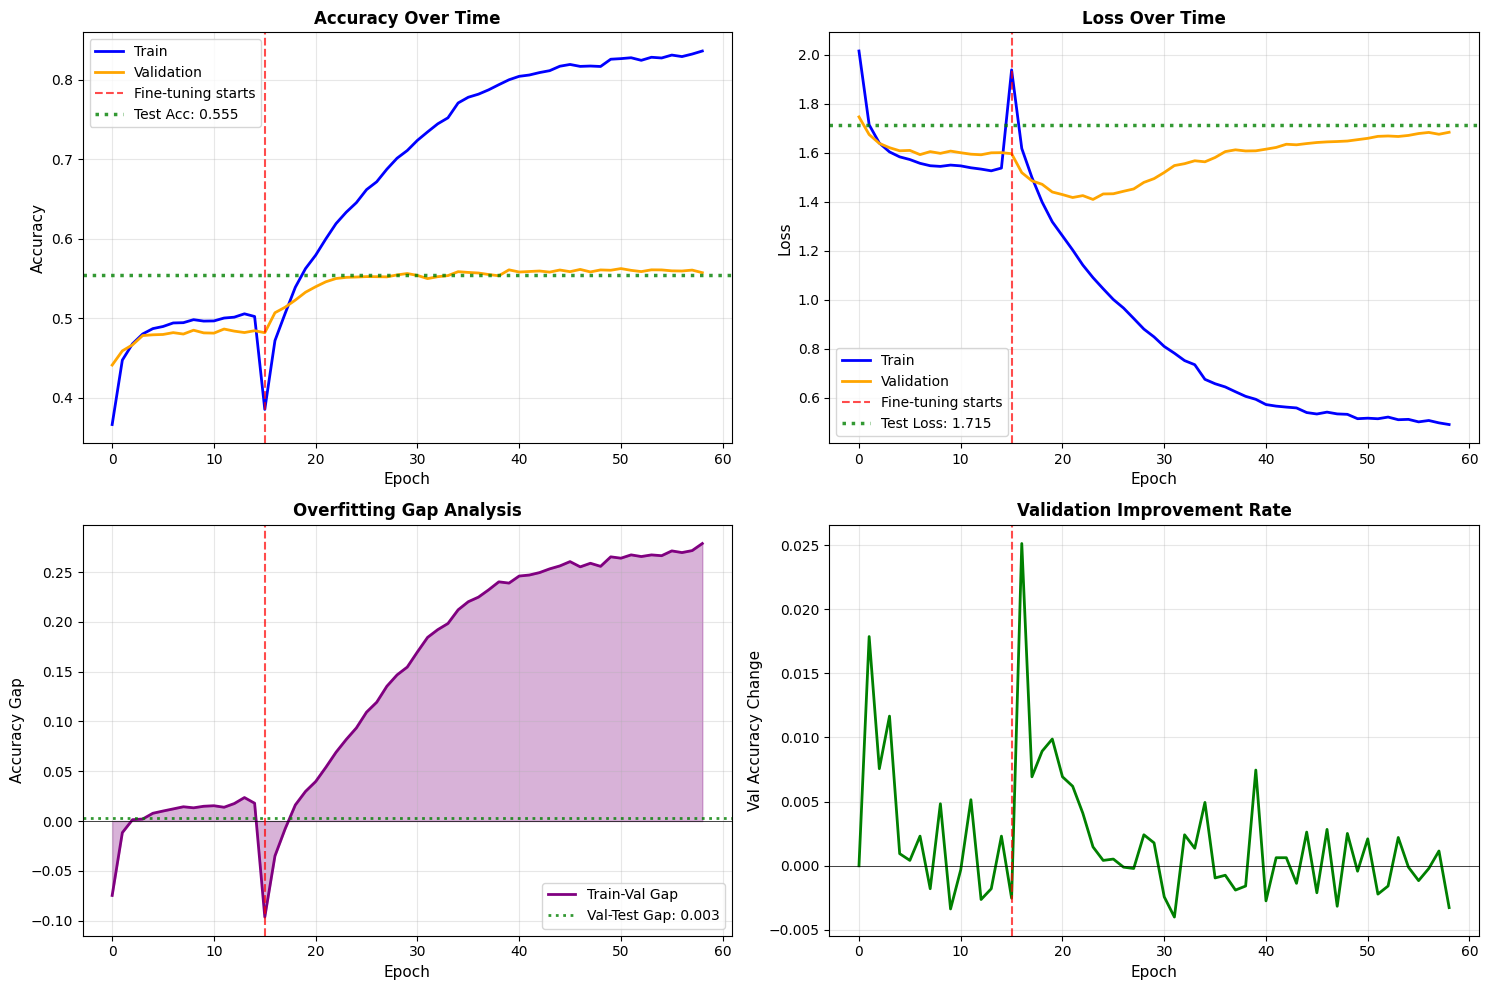


FINAL PERFORMANCE SUMMARY
Final Train Accuracy:      0.8359
Final Validation Accuracy: 0.5573
Test Accuracy:             0.5547

Train-Val Gap:   +0.2786
Val-Test Gap:    +0.0027
Train-Test Gap:  +0.2813
✅ GOOD: Validation and test accuracy are very close!
   Model generalizes well to unseen data.


In [ ]:
print("\n--- Training Dynamics Analysis ---")

# Combine all history
all_epochs = len(history1.history['accuracy']) + len(history2.history['accuracy'])
stage1_epochs = len(history1.history['accuracy'])

# Combine accuracies and losses from both stages
acc = history1.history['accuracy'] + history2.history['accuracy']
val_acc = history1.history['val_accuracy'] + history2.history['val_accuracy']
loss = history1.history['loss'] + history2.history['loss']
val_loss = history1.history['val_loss'] + history2.history['val_loss']

# Plot detailed learning curves
fig, axes = plt.subplots(2, 2, figsize=(15, 10))

# Accuracy
axes[0, 0].plot(range(all_epochs), acc, label='Train', linewidth=2, color='blue')
axes[0, 0].plot(range(all_epochs), val_acc, label='Validation', linewidth=2, color='orange')
axes[0, 0].axvline(x=stage1_epochs, color='red', linestyle='--', linewidth=1.5, alpha=0.7, label='Fine-tuning starts')
# Add test accuracy as horizontal line
axes[0, 0].axhline(y=test_acc, color='green', linestyle=':', linewidth=2.5, alpha=0.8, label=f'Test Acc: {test_acc:.3f}')
axes[0, 0].set_xlabel('Epoch', fontsize=11)
axes[0, 0].set_ylabel('Accuracy', fontsize=11)
axes[0, 0].set_title('Accuracy Over Time', fontsize=12, fontweight='bold')
axes[0, 0].legend()
axes[0, 0].grid(alpha=0.3)

# Loss
axes[0, 1].plot(range(all_epochs), loss, label='Train', linewidth=2, color='blue')
axes[0, 1].plot(range(all_epochs), val_loss, label='Validation', linewidth=2, color='orange')
axes[0, 1].axvline(x=stage1_epochs, color='red', linestyle='--', linewidth=1.5, alpha=0.7, label='Fine-tuning starts')
# Add test loss as horizontal line
axes[0, 1].axhline(y=test_loss, color='green', linestyle=':', linewidth=2.5, alpha=0.8, label=f'Test Loss: {test_loss:.3f}')
axes[0, 1].set_xlabel('Epoch', fontsize=11)
axes[0, 1].set_ylabel('Loss', fontsize=11)
axes[0, 1].set_title('Loss Over Time', fontsize=12, fontweight='bold')
axes[0, 1].legend()
axes[0, 1].grid(alpha=0.3)

# Overfitting gap
gap = [t - v for t, v in zip(acc, val_acc)]
axes[1, 0].plot(range(all_epochs), gap, linewidth=2, color='purple', label='Train-Val Gap')
axes[1, 0].axhline(y=0, color='black', linestyle='-', linewidth=0.5)
axes[1, 0].axvline(x=stage1_epochs, color='red', linestyle='--', linewidth=1.5, alpha=0.7)
axes[1, 0].fill_between(range(all_epochs), 0, gap, alpha=0.3, color='purple')
# Add final val-test gap
final_val_acc = val_acc[-1]
val_test_gap = final_val_acc - test_acc
axes[1, 0].axhline(y=val_test_gap, color='green', linestyle=':', linewidth=2, alpha=0.8,
                   label=f'Val-Test Gap: {val_test_gap:.3f}')
axes[1, 0].set_xlabel('Epoch', fontsize=11)
axes[1, 0].set_ylabel('Accuracy Gap', fontsize=11)
axes[1, 0].set_title('Overfitting Gap Analysis', fontsize=12, fontweight='bold')
axes[1, 0].legend()
axes[1, 0].grid(alpha=0.3)

# Validation improvement rate
val_acc_diff = [0] + [val_acc[i] - val_acc[i-1] for i in range(1, len(val_acc))]
axes[1, 1].plot(range(all_epochs), val_acc_diff, linewidth=2, color='green')
axes[1, 1].axhline(y=0, color='black', linestyle='-', linewidth=0.5)
axes[1, 1].axvline(x=stage1_epochs, color='red', linestyle='--', linewidth=1.5, alpha=0.7)
axes[1, 1].set_xlabel('Epoch', fontsize=11)
axes[1, 1].set_ylabel('Val Accuracy Change', fontsize=11)
axes[1, 1].set_title('Validation Improvement Rate', fontsize=12, fontweight='bold')
axes[1, 1].grid(alpha=0.3)

plt.tight_layout()
plt.savefig('/content/learning_dynamics.png', dpi=150, bbox_inches='tight')
plt.show()

# Print summary comparison
print("\n" + "="*60)
print("FINAL PERFORMANCE SUMMARY")
print("="*60)
print(f"Final Train Accuracy:      {acc[-1]:.4f}")
print(f"Final Validation Accuracy: {val_acc[-1]:.4f}")
print(f"Test Accuracy:             {test_acc:.4f}")
print(f"\nTrain-Val Gap:   {acc[-1] - val_acc[-1]:+.4f}")
print(f"Val-Test Gap:    {val_acc[-1] - test_acc:+.4f}")
print(f"Train-Test Gap:  {acc[-1] - test_acc:+.4f}")
print("="*60)

# Interpretation
if abs(val_acc[-1] - test_acc) < 0.02:
    print("✅ GOOD: Validation and test accuracy are very close!")
    print("   Model generalizes well to unseen data.")
elif val_acc[-1] > test_acc + 0.02:
    print("⚠️  WARNING: Validation accuracy > Test accuracy")
    print("   Possible overfitting to validation set.")
else:
    print("🎉 EXCELLENT: Test accuracy > Validation accuracy")
    print("   Model generalizes even better than expected!")

## Interpretation of Training/Testing Results
####1. **Test Accuracy:**
55.5% is acceptable but there is still room for improvement. For 23 art style classes, this is number is above random chance
####2. **Overfitting is the Main problem:**
- ***Train-Val Gap***: +27.9% (Training 83.6% vs Validation 55.7%)
    - This number is very high -indicates severe overfitting
    - The model memorizes training data but doesn't generalize well
    - After fine-tuning starts (red line), the gap grows dramatically
- ***Val-Test Gap is +0.3% is good***: Validation and test performance are nearly identical. This means my validation set is representative. the model isn't overfitting to the validation set.
####3. **Traning Dynamic Analysis:**
- ***Stage 1 (Epoch 0-15): Good***
    - Both training and val accuracy improve together
    - Small overfitting gap
    - Model learns general features well
- ***Stage 2 (Epoch 15-60):***
    - Sharp drop at epoch 15: Model resets when fine-tuning starts (expected)
    - Training accuracy increases (50% → 83.6%)
    - Validation accuracy plateaus (stays around 55-56%)
    - Overfitting gap explodes (0% → 28%)
- ***Loss Analysis:***
    - Training loss drops steadily (0.5 → ~0.5)
    - Validation loss increases after epoch 15 (1.5 → 1.7)
    - Test loss (1.715) is higher than validation loss - slight generalization gap

- ***Validation Improvement Rate:***

    - Nearly flat after epoch 20
    - Small fluctuations around 0%
    - Model stopped improving on unseen data
####4. **Possible causes:**
- ***Primary Issue: Aggressive Fine-Tuning***

    - Unfroze too many layers (50) with complex data
    - Learning rate too high (0.00008) for fine-tuning
    - Not enough regularization to prevent overfitting
    - Data augmentation wasn't strong enough to compensate

- ***Secondary Issues:***

    - 43,000 images is small for 2.5M parameters
    - The model is likely learning artist specific patterns rather than style-defining features, which leads to overfitting


# VI. Visualize Predictions with Confidence

Each image shows:

- **True:** the actual art style label (in green text)

- **Pred:** the model’s predicted label (green if correct, red if wrong)

- **Conf:** the model’s prediction confidence (probability assigned to the predicted class)

The figure illustrates both correct and incorrect predictions, helping evaluate the model’s behavior visually.

Found 4774 files belonging to 23 classes.


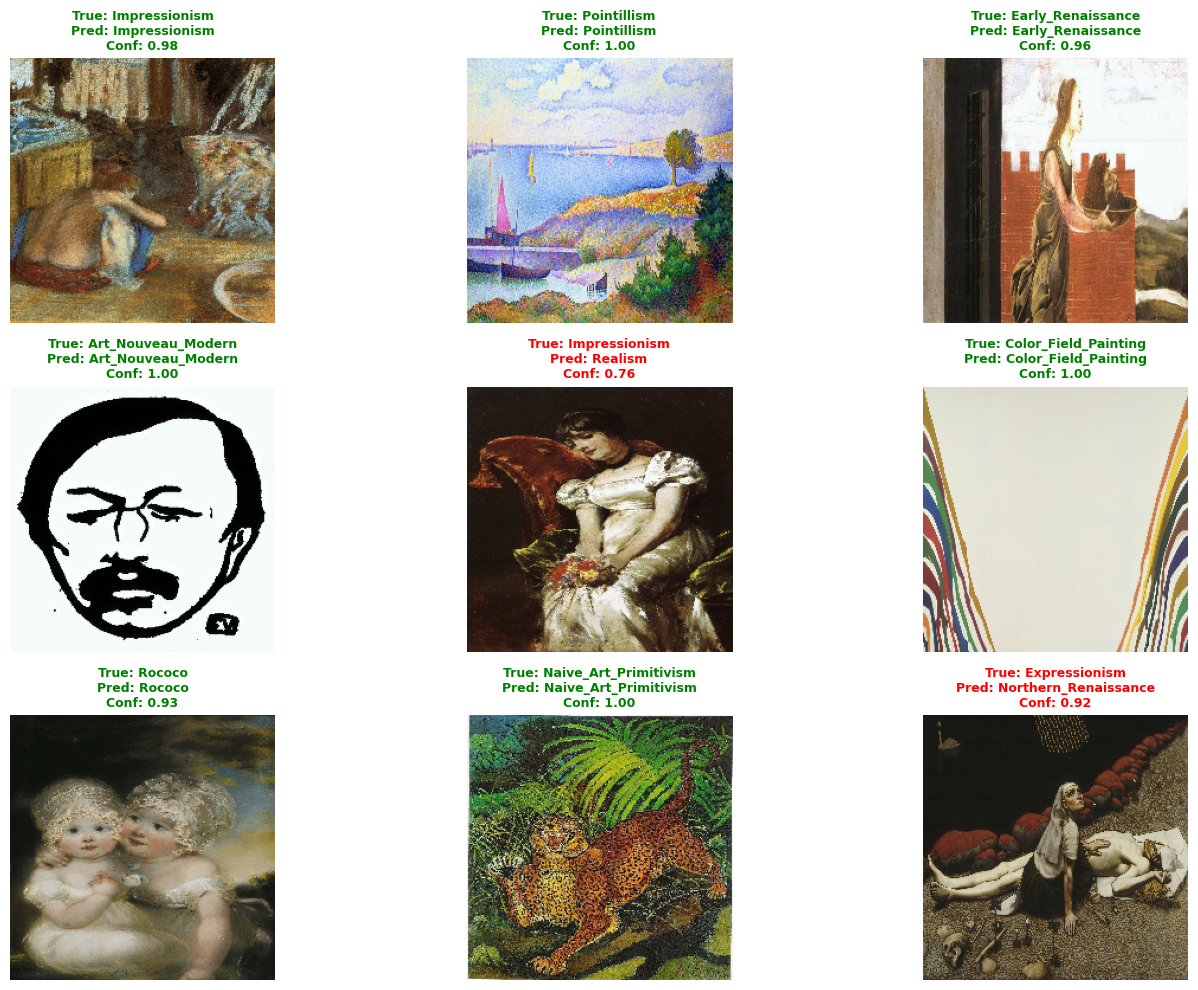

In [ ]:

# Get a batch from test set for predictions
test_images_raw = tf.keras.utils.image_dataset_from_directory(
    directory="/content/wikiart_capped/test",
    image_size=(224, 224),
    batch_size=9,
    seed=None,
    shuffle=True,
    label_mode='categorical'
)

images_display, labels_display = next(iter(test_images_raw))

# Preprocess for prediction
images_pred = tf.keras.applications.efficientnet.preprocess_input(images_display)
predictions = model.predict(images_pred, verbose=0)

# Visualize
plt.figure(figsize=(15, 10))
for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(images_display[i].numpy().astype('uint8'))

    true_idx = labels_display[i].numpy().argmax()
    pred_idx = predictions[i].argmax()
    true_label = class_names[true_idx]
    pred_label = class_names[pred_idx]
    confidence = predictions[i].max()

    color = 'green' if true_idx == pred_idx else 'red'
    plt.title(f"True: {true_label}\nPred: {pred_label}\nConf: {confidence:.2f}",
              color=color, fontsize=9, fontweight='bold')
    plt.axis("off")
plt.tight_layout()
plt.show()


**Prediction Confidence Analysis**
1. ***Correct Predictions (High Confidence ≥0.93)***
All correctly classified paintings have high confidence levels (0.93-1.00). The model is confident because these paintings have distinctive visual signatures:

  - Pointillism (1.00): Unmistakable dot technique
  - Art Nouveau (1.00): Bold black outlines and decorative style
  - Color Field Painting (1.00): Large minimalist geometric forms
  - Naïve Art (1.00): Primitive style with flat colors and simplified forms
  - Early Renaissance (0.96): Religious iconography with gold/architectural backgrounds
  - Rococo (0.93): Soft, dreamy cherubs with characteristic pastel tones

2. ***Wrong Predictions (But Still High Confidence)***
- The woman on the chair painting (Impressionism → Realism (Conf: 0.76)): Why confusion is understandable:
    - Dark background and realistic rendering of figure,
    - Less visible brushstrokes than typical Impressionism
- The woman with a death body painting (Expressionism → Northern Renaissance (Conf: 0.92)). Why confusion:
    - Dark background and dramatic lighting (reminiscent of Renaissance chiaroscuro)
   
    - Muted earth tones instead of typical Expressionist bold colors

# VII. Detailed Performance Analysis

## Confusion matrix

The confusion matrix is a comprehensive visualization that compares true labels (actual art styles) with predicted labels (what the model predicted) across all 23 art style classes in our test set.


- Y-axis (True Label): The actual/correct art style of each painting
- X-axis (Predicted Label): What the model predicted the style to be
Colors & Values

- Dark blue diagonal: Correct predictions (True label = Predicted label)
- Lighter blue off-diagonal: Misclassifications (model got it wrong)
- White/very light: Few or no predictions in that cell
- Color intensity: Darker = more images in that category
- The Diagonal Line:
The strong dark blue diagonal running from top-left to bottom-right represents correct predictions. The darker these cells, the better the model performs for that class.

This visualization helps identify which classes are being correctly predicted and where misclassifications occur.

Confusion matrix
Total predictions: 4774
Total labels: 4774
Accuracy check: 0.555


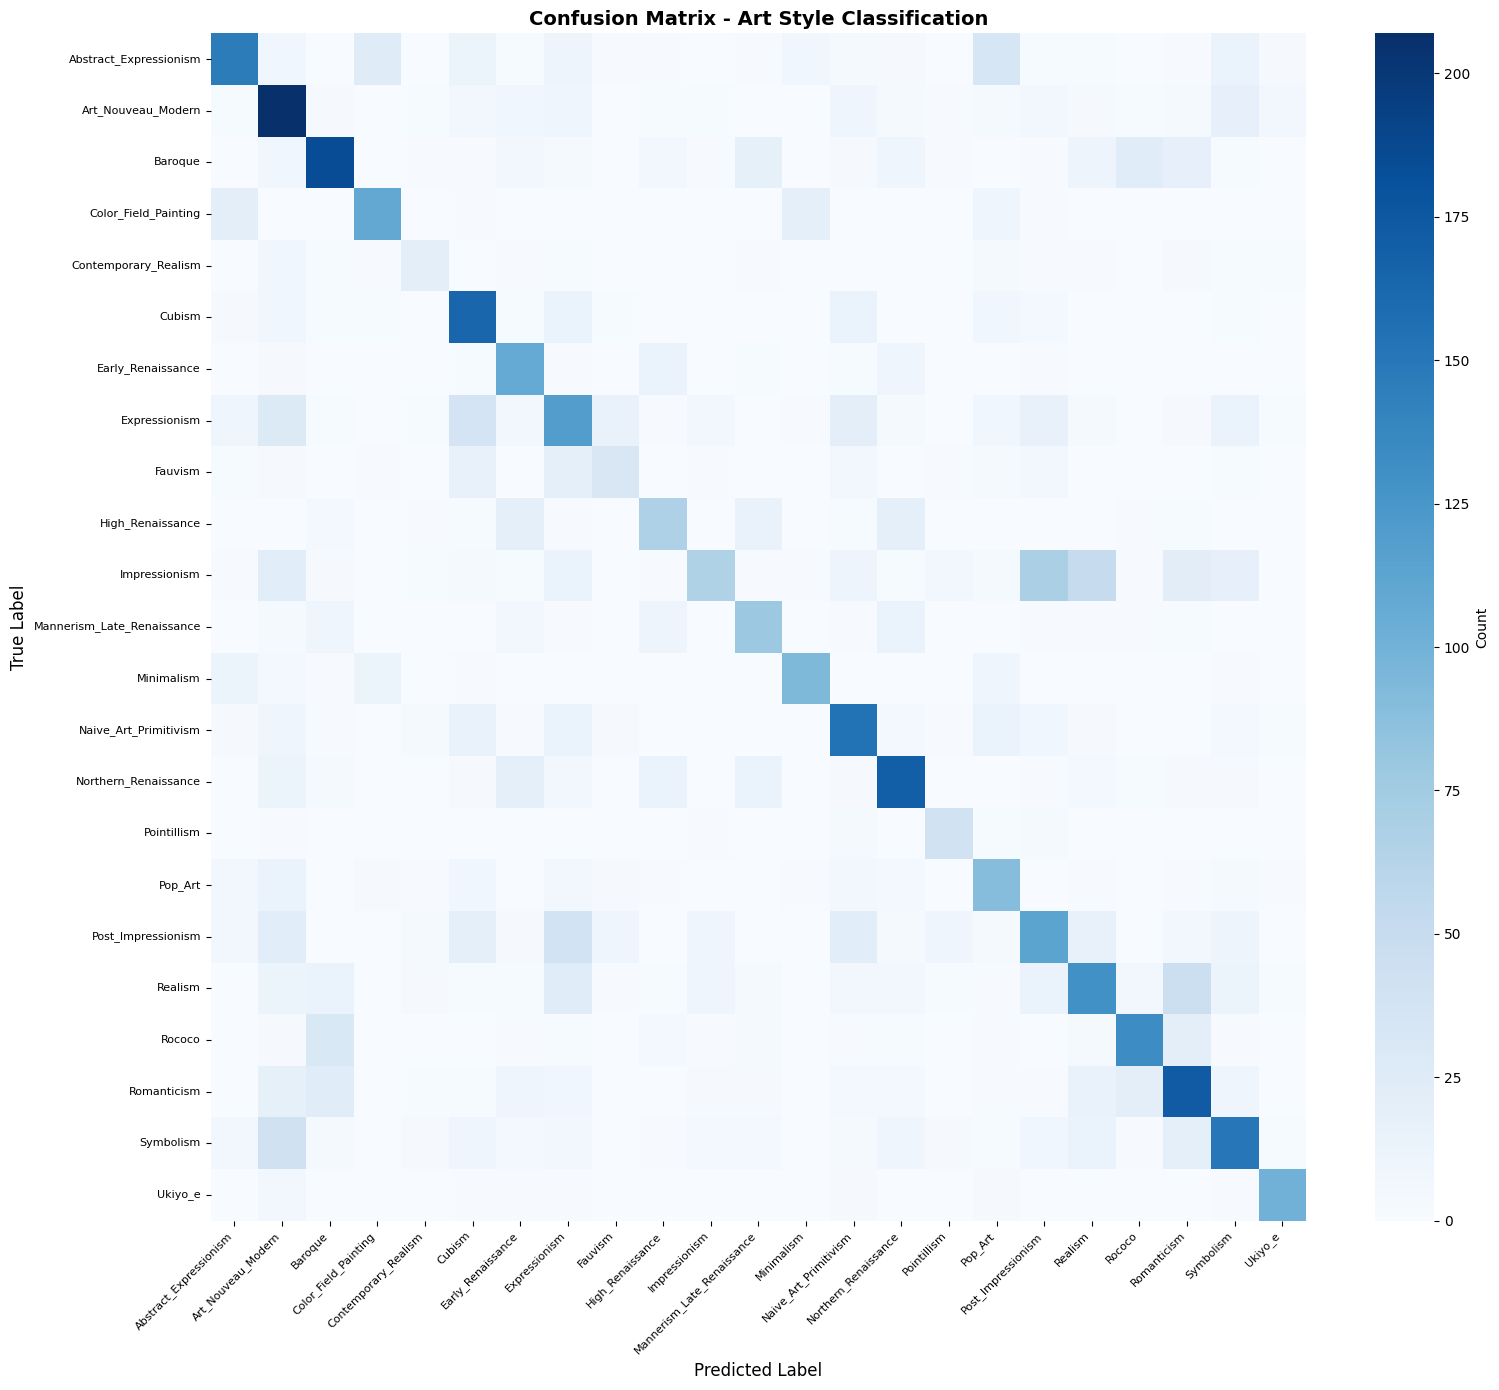

Confusion matrix saved to: /content/confusion_matrix.png


In [ ]:
print("Confusion matrix")

all_preds = []
all_labels = []

# Clear any previous data
test_ds_fresh = test_ds.map(preprocess).prefetch(tf.data.AUTOTUNE)

for images, labels in test_ds_fresh:
    batch_preds = model.predict(images, verbose=0)
    all_preds.extend(batch_preds.argmax(axis=1))
    all_labels.extend(labels.numpy().argmax(axis=1))

all_preds = np.array(all_preds)
all_labels = np.array(all_labels)

# Verify counts
print(f"Total predictions: {len(all_preds)}")
print(f"Total labels: {len(all_labels)}")
print(f"Accuracy check: {(all_preds == all_labels).mean():.3f}")  # Should be ~0.555

# Generate confusion matrix
from sklearn.metrics import confusion_matrix, classification_report
cm = confusion_matrix(all_labels, all_preds)
plt.figure(figsize=(16, 14))
sns.heatmap(cm, annot=False, fmt='d', cmap='Blues',
            xticklabels=class_names, yticklabels=class_names,
            cbar_kws={'label': 'Count'})
plt.title('Confusion Matrix - Art Style Classification', fontsize=14, fontweight='bold')
plt.xlabel('Predicted Label', fontsize=12)
plt.ylabel('True Label', fontsize=12)
plt.xticks(rotation=45, ha='right', fontsize=8)
plt.yticks(rotation=0, fontsize=8)
plt.tight_layout()
plt.savefig('/content/confusion_matrix.png', dpi=150, bbox_inches='tight')
plt.show()
print("Confusion matrix saved to: /content/confusion_matrix.png")

**Key Patterns Visible in the Matrix**

**1. Strong Performers (Dark Diagonal)**
Classes with ***intense dark blue*** on the diagonal:
- Art_Nouveau_Modern
- Northern_Renaissance
- Baroque
- Romanticism

These styles have distinct visual features the model learned well.

**2. Confusion Clusters (Off-Diagonal Blues)**

***Impressionism ↔ Post_Impressionism***
- Large light blue cells off the diagonal
- These styles are historically and visually related
- Expected confusion

***Realism ↔ Romanticism***  
- Visible off-diagonal activity
- Both use naturalistic rendering
- Subtle differences are hard to capture

***Renaissance Family Confusion***
- Early_Renaissance, High_Renaissance, Mannerism_Late_Renaissance
- Light blue cells between these rows/columns
- Similar time periods and techniques

**3. Scattered Predictions (Light Blues Everywhere)**
Some rows (true labels) have **many light blue cells** across multiple columns:
- Expressionism: Confused with Cubism, Fauvism, Abstract_Expressionism
- Contemporary_Realism: Scattered predictions across modern styles

This indicates the model struggles to distinguish these styles from others.

## Misclassification Patterns

This part identifies and ranks the most common prediction errors, showing which art style pairs the model confuses most frequently (e.g., Impressionism → Post-Impressionism happened 69 times).

These code below create a ranked table and bar chart of the top 10-15 most frequent misclassification patterns to reveal where the model struggles.


--- Detailed Misclassification Analysis ---

Top 15 Most Frequent Misclassifications:
Rank   True Class                     Predicted As                   Count    % of True Class
----------------------------------------------------------------------------------------------------
1      Impressionism                  Post_Impressionism             69         23.0%
2      Impressionism                  Realism                        51         17.0%
3      Realism                        Romanticism                    46         15.3%
4      Symbolism                      Art_Nouveau_Modern             42         14.0%
5      Post_Impressionism             Expressionism                  39         13.0%
6      Expressionism                  Cubism                         37         12.3%
7      Abstract_Expressionism         Pop_Art                        34         12.2%
8      Rococo                         Baroque                        31         14.8%
9      Expressionism          

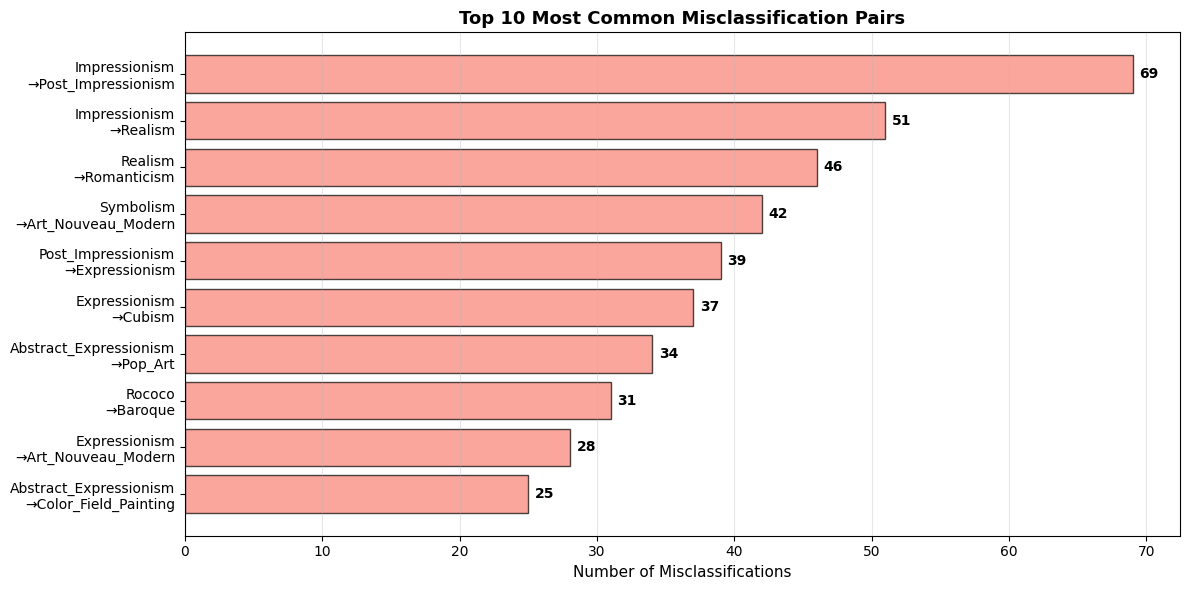

In [ ]:


print("\n--- Detailed Misclassification Analysis ---")

# Find most common misclassifications
from collections import defaultdict
misclassifications = defaultdict(int)

for true_label, pred_label in zip(all_labels, all_preds):
    if true_label != pred_label:
        misclassifications[(class_names[true_label], class_names[pred_label])] += 1

# Sort by frequency
sorted_misclass = sorted(misclassifications.items(), key=lambda x: x[1], reverse=True)

print("\nTop 15 Most Frequent Misclassifications:")
print(f"{'Rank':<6} {'True Class':<30} {'Predicted As':<30} {'Count':<8} {'% of True Class'}")
print("-" * 100)

for rank, ((true_class, pred_class), count) in enumerate(sorted_misclass[:15], 1):
    true_class_idx = class_names.index(true_class)
    true_class_total = (all_labels == true_class_idx).sum()
    percentage = (count / true_class_total) * 100 if true_class_total > 0 else 0
    print(f"{rank:<6} {true_class:<30} {pred_class:<30} {count:<8} {percentage:>6.1f}%")

# Visualize top misclassifications
top_10_misclass = sorted_misclass[:10]
true_classes = [f"{tc}\n→{pc}" for (tc, pc), _ in top_10_misclass]
counts = [count for _, count in top_10_misclass]

plt.figure(figsize=(12, 6))
bars = plt.barh(true_classes, counts, color='salmon', edgecolor='black', alpha=0.7)
plt.xlabel('Number of Misclassifications', fontsize=11)
plt.title('Top 10 Most Common Misclassification Pairs', fontsize=13, fontweight='bold')
plt.gca().invert_yaxis()
for bar, count in zip(bars, counts):
    plt.text(count + 0.5, bar.get_y() + bar.get_height()/2,
             str(count), va='center', fontsize=10, fontweight='bold')
plt.grid(axis='x', alpha=0.3)
plt.tight_layout()
plt.savefig('/content/top_misclassifications.png', dpi=150, bbox_inches='tight')
plt.show()

**Analysis of Misclassification Patterns**

**Top Confusion Pairs & Why**
1. ***Impressionism → Post-Impressionism*** (69 errors, 23%)

    - Post-Impressionism evolved directly from Impressionism
    - Share: brushstrokes, light effects, vibrant colors
    - Artists like Van Gogh bridged both styles

2. ***Impressionism → Realism*** (51 errors, 17%)

    - Both depict everyday life and landscapes
    - Impressionism emerged from Realism
    - Difference is subtle: sharp vs. loose brushwork

3. ***Realism → Romanticism*** (46 errors, 15.3%)

    - Both paint nature/historical scenes with traditional techniques
    - Romanticism focuses on emotion, Realism focuses on observation but they have blurry line

4. ***Symbolism → Art Nouveau*** (42 errors, 14%)

    - Both peaked 1890s-1910s
    - Share: decorative elements, mystical themes
    - Artists like Klimt worked in both

5. ***Post-Impressionism → Expressionism*** (39 errors, 13%)

    - Van Gogh's late work bridges both
    - Both use emotional color and distorted forms
**Conclusion**

The model frequently confuses art styles that fall into three categories:

- Historical transitions (e.g., Impressionism → Post-Impressionism)
- Visual similarity (e.g., Expressionism → Cubism due to geometric forms)
- Overlapping categories (e.g., Abstract Expressionism → Color Field Painting, which are related movements)

This confusion is acceptable because the model's mistakes mirror the same debates and ambiguities that exist among art historians. The boundaries between many art movements are inherently blurry, and the model's errors reflect genuine artistic relationships rather than random misclassification.

## Per-Class Performance Deep Dive
This part analyzes individual class performance by calculating accuracy, confidence scores, and sample counts for each of the 23 art styles.

Ranks classes from best to worst performers and visualizes the top 5 best vs. top 5 worst with side-by-side bar charts.


---  Per-Class Performance Breakdown ---

Per-Class Performance (Sorted by Accuracy):
Rank   Class                          Accuracy   Correct/Total   Avg Conf    
--------------------------------------------------------------------------------
1      Ukiyo_e                         85.6%     101/118         0.831
2      Pointillism                     76.9%      40/52          0.732
3      Early_Renaissance               76.4%     107/140         0.700
4      Cubism                          73.2%     164/224         0.707
5      Art_Nouveau_Modern              69.0%     207/300         0.628
6      Minimalism                      68.9%      93/135         0.646
7      Color_Field_Painting            67.3%     109/162         0.648
8      Northern_Renaissance            66.0%     169/256         0.632
9      Naive_Art_Primitivism           63.9%     154/241         0.596
10     Rococo                          63.3%     133/210         0.599
11     Baroque                         61.7%

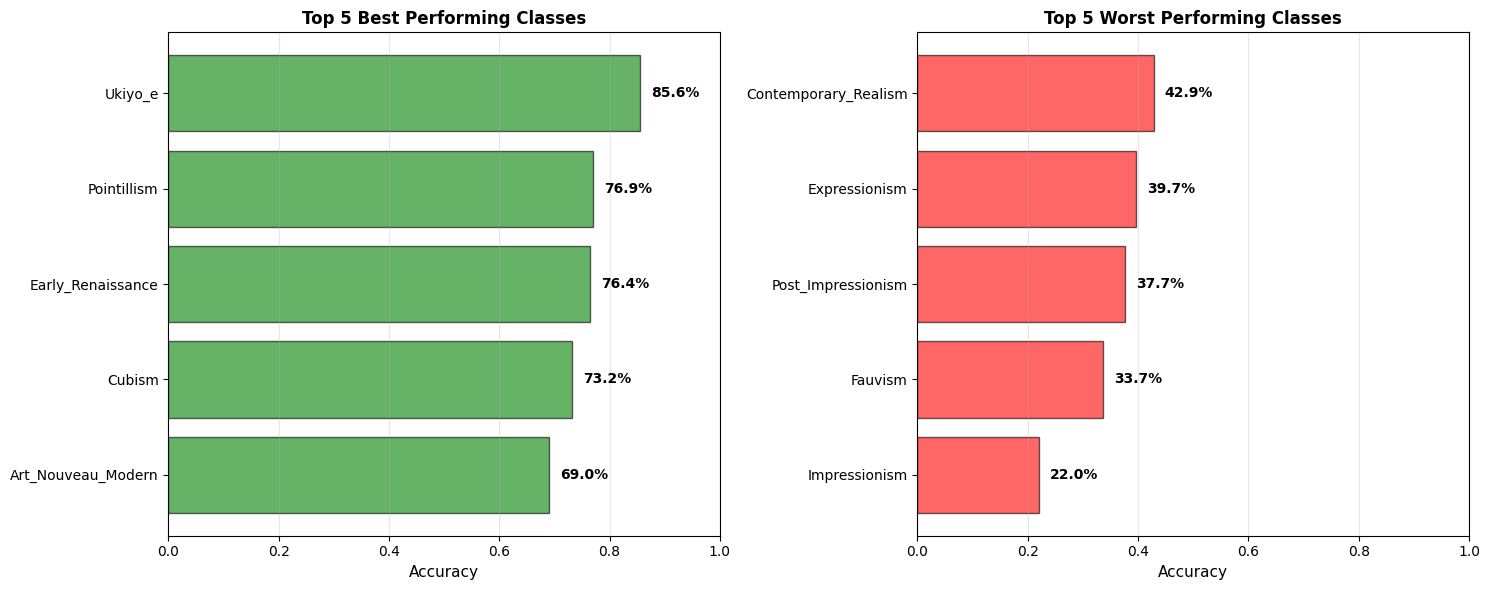

In [ ]:
print("\n---  Per-Class Performance Breakdown ---")

# Get all predictions on test set and their probabilities
all_preds = []
all_labels = []
all_predictions_probs = [] # Define the variable here

for images, labels in test_ds_processed:
    preds = model.predict(images, verbose=0)
    all_preds.extend(preds.argmax(axis=1))
    all_labels.extend(labels.numpy().argmax(axis=1))
    all_predictions_probs.extend(preds) # Append probabilities

all_preds = np.array(all_preds)
all_labels = np.array(all_labels)
all_predictions_probs = np.array(all_predictions_probs) # Convert to numpy array

# Calculate detailed metrics per class
class_metrics = []
for i, class_name in enumerate(class_names):
    mask = all_labels == i
    if mask.sum() == 0:
        continue

    # Basic metrics
    support = mask.sum()
    correct = (all_preds[mask] == all_labels[mask]).sum()
    accuracy = correct / support

    # Confidence for this class
    class_confidences = all_predictions_probs[mask, i]
    avg_confidence = class_confidences.mean()

    # When predicted as this class
    pred_mask = all_preds == i
    if pred_mask.sum() > 0:
        precision_conf = all_predictions_probs[pred_mask][:, i].mean()
    else:
        precision_conf = 0

    class_metrics.append({
        'class': class_name,
        'support': support,
        'accuracy': accuracy,
        'correct': correct,
        'avg_confidence': avg_confidence,
        'precision_conf': precision_conf
    })

# Sort by accuracy
class_metrics_sorted = sorted(class_metrics, key=lambda x: x['accuracy'], reverse=True)

print("\nPer-Class Performance (Sorted by Accuracy):")
print(f"{'Rank':<6} {'Class':<30} {'Accuracy':<10} {'Correct/Total':<15} {'Avg Conf':<12}")
print("-" * 80)
for rank, metrics in enumerate(class_metrics_sorted, 1):
    print(f"{rank:<6} {metrics['class']:<30} {metrics['accuracy']:>6.1%}    "
          f"{metrics['correct']:>4}/{metrics['support']:<8} {metrics['avg_confidence']:>8.3f}")

# Visualize best vs worst classes
best_5 = class_metrics_sorted[:5]
worst_5 = class_metrics_sorted[-5:]

fig, axes = plt.subplots(1, 2, figsize=(15, 6))

# Best performing
best_names = [m['class'] for m in best_5]
best_accs = [m['accuracy'] for m in best_5]
axes[0].barh(best_names, best_accs, color='green', alpha=0.6, edgecolor='black')
axes[0].set_xlabel('Accuracy', fontsize=11)
axes[0].set_title('Top 5 Best Performing Classes', fontsize=12, fontweight='bold')
axes[0].set_xlim(0, 1)
axes[0].invert_yaxis()
for i, (name, acc) in enumerate(zip(best_names, best_accs)):
    axes[0].text(acc + 0.02, i, f'{acc:.1%}', va='center', fontsize=10, fontweight='bold')
axes[0].grid(axis='x', alpha=0.3)

# Worst performing
worst_names = [m['class'] for m in worst_5]
worst_accs = [m['accuracy'] for m in worst_5]
axes[1].barh(worst_names, worst_accs, color='red', alpha=0.6, edgecolor='black')
axes[1].set_xlabel('Accuracy', fontsize=11)
axes[1].set_title('Top 5 Worst Performing Classes', fontsize=12, fontweight='bold')
axes[1].set_xlim(0, 1)
axes[1].invert_yaxis()
for i, (name, acc) in enumerate(zip(worst_names, worst_accs)):
    axes[1].text(acc + 0.02, i, f'{acc:.1%}', va='center', fontsize=10, fontweight='bold')
axes[1].grid(axis='x', alpha=0.3)


plt.tight_layout()
plt.savefig('/content/best_worst_classes.png', dpi=150, bbox_inches='tight')
plt.show()

**Observation:**

We cannot directly relate dataset size to model performance. For example, Ukiyo_e and Pointillism are among the smallest categories, yet the model performs very well on them. In contrast, Expressionism and Post-Impressionism have some of the largest datasets, but their accuracies remain low.

This suggests that dataset size alone does not determine classification performance — rather, the distinctiveness of visual features within a style plays a more significant role. Styles with unique color palettes, brushstrokes, or compositions (like Ukiyo_e) are easier for the model to recognize, while visually overlapping styles (such as Expressionism and Post-Impressionism) cause more confusion despite having more samples.

## Visualizing Classification Metrics by Class

This chart shows the precision, recall, and F1-score for each of the 23 art styles in the test set.

- Precision measures how often the model’s predictions for a class are correct.

- Recall measures how well the model detects all true instances of that class.

- F1-score is the harmonic mean of precision and recall — it balances both metrics.




--- Visualizing Classification Metrics by Class ---

Classification Metrics Summary:
                     Class  Precision   Recall  F1-Score  Support
                   Ukiyo_e   0.834711 0.855932  0.845188      118
                Minimalism   0.750000 0.688889  0.718147      135
      Color_Field_Painting   0.712418 0.672840  0.692063      162
               Pointillism   0.615385 0.769231  0.683761       52
                    Rococo   0.689119 0.633333  0.660050      210
      Northern_Renaissance   0.625926 0.660156  0.642586      256
         Early_Renaissance   0.532338 0.764286  0.627566      140
                   Baroque   0.637931 0.616667  0.627119      300
                    Cubism   0.532468 0.732143  0.616541      224
     Naive_Art_Primitivism   0.548043 0.639004  0.590038      241
    Abstract_Expressionism   0.668182 0.526882  0.589178      279
Mannerism_Late_Renaissance   0.541096 0.612403  0.574545      129
        Art_Nouveau_Modern   0.465169 0.690000  0.555705

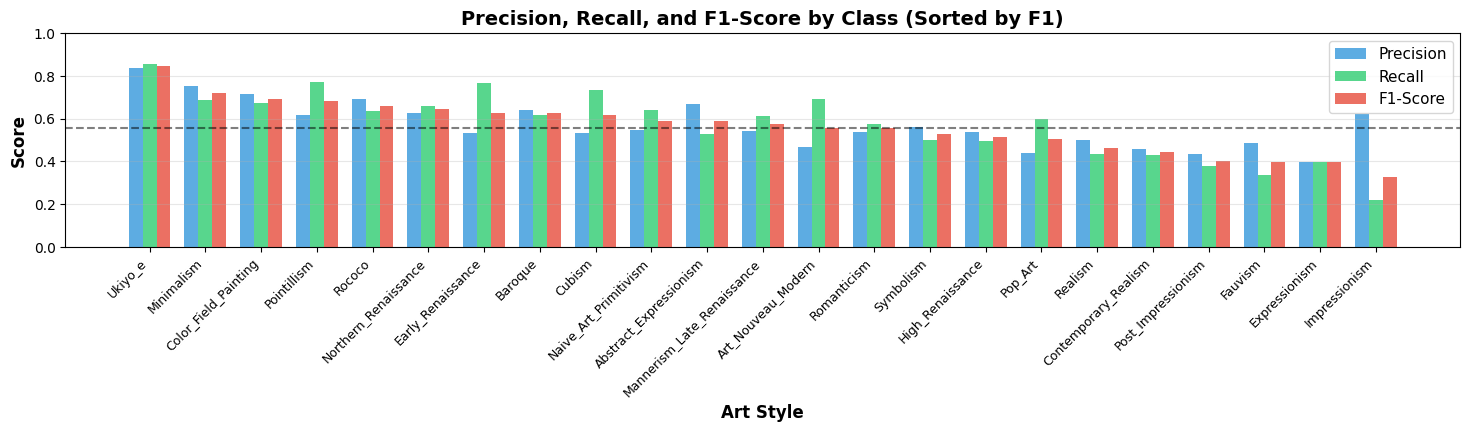

In [ ]:
print("\n--- Visualizing Classification Metrics by Class ---")

# Get precision, recall, f1 for each class


precision, recall, f1, support = precision_recall_fscore_support(
    all_labels, all_preds, average=None, labels=range(len(class_names))
)

# Create DataFrame for easier manipulation

metrics_df = pd.DataFrame({
    'Class': class_names,
    'Precision': precision,
    'Recall': recall,
    'F1-Score': f1,
    'Support': support
})

# Sort by F1-score
metrics_df = metrics_df.sort_values('F1-Score', ascending=False)

print("\nClassification Metrics Summary:")
print(metrics_df.to_string(index=False))

# --- Subplot 1: Precision, Recall, F1 for All Classes ---
fig = plt.figure(figsize=(18, 10))
gs = fig.add_gridspec(3, 2, hspace=0.3, wspace=0.3)

# Top plot: Grouped bar chart for all metrics
ax1 = fig.add_subplot(gs[0, :])
x = np.arange(len(class_names))
width = 0.25

bars1 = ax1.bar(x - width, metrics_df['Precision'], width, label='Precision', color='#3498db', alpha=0.8)
bars2 = ax1.bar(x, metrics_df['Recall'], width, label='Recall', color='#2ecc71', alpha=0.8)
bars3 = ax1.bar(x + width, metrics_df['F1-Score'], width, label='F1-Score', color='#e74c3c', alpha=0.8)

ax1.set_xlabel('Art Style', fontsize=12, fontweight='bold')
ax1.set_ylabel('Score', fontsize=12, fontweight='bold')
ax1.set_title('Precision, Recall, and F1-Score by Class (Sorted by F1)', fontsize=14, fontweight='bold')
ax1.set_xticks(x)
ax1.set_xticklabels(metrics_df['Class'], rotation=45, ha='right', fontsize=9)
ax1.legend(fontsize=11)
ax1.grid(axis='y', alpha=0.3)
ax1.set_ylim(0, 1)

# Add horizontal line at overall accuracy
overall_acc = (all_preds == all_labels).mean()
ax1.axhline(y=overall_acc, color='black', linestyle='--', linewidth=1.5, alpha=0.5, label=f'Overall Acc: {overall_acc:.3f}')



**Interpretation**

***1. Best-performing classes:***

Ukiyo_e (F1 = 0.85), Minimalism (0.72), Color_Field_Painting (0.69), and Pointillism (0.68) achieved strong F1-scores, showing the model identifies these distinct visual styles accurately.
These styles have unique textures, compositions, or color patterns that make them easier to classify.

***2. Moderate performance:***

Styles such as Baroque, Cubism, Rococo, and Early_Renaissance (F1 ≈ 0.60–0.63) are moderately consistent.
The model can recognize them but still confuses them with stylistically similar categories.

***3. Lower-performing classes:***

Expressionism (0.40), Post_Impressionism (0.40), Fauvism (0.40), and Impressionism (0.33) have the weakest F1-scores.
These categories often share overlapping visual elements (color blending, brushstroke patterns), making them difficult to distinguish even with a fine-tuned CNN.

##ROC Curve by Class

- **ROC curve:** Plots the True Positive Rate (TPR) on the y-axis against the False Positive Rate (FPR) on the x-axis at different classification thresholds

- **The per-class AUC (Area Under the ROC Curve)** measures how well the model distinguishes each art style from the others.


--- ROC Curve by Class (Split into 4 Panels) ---


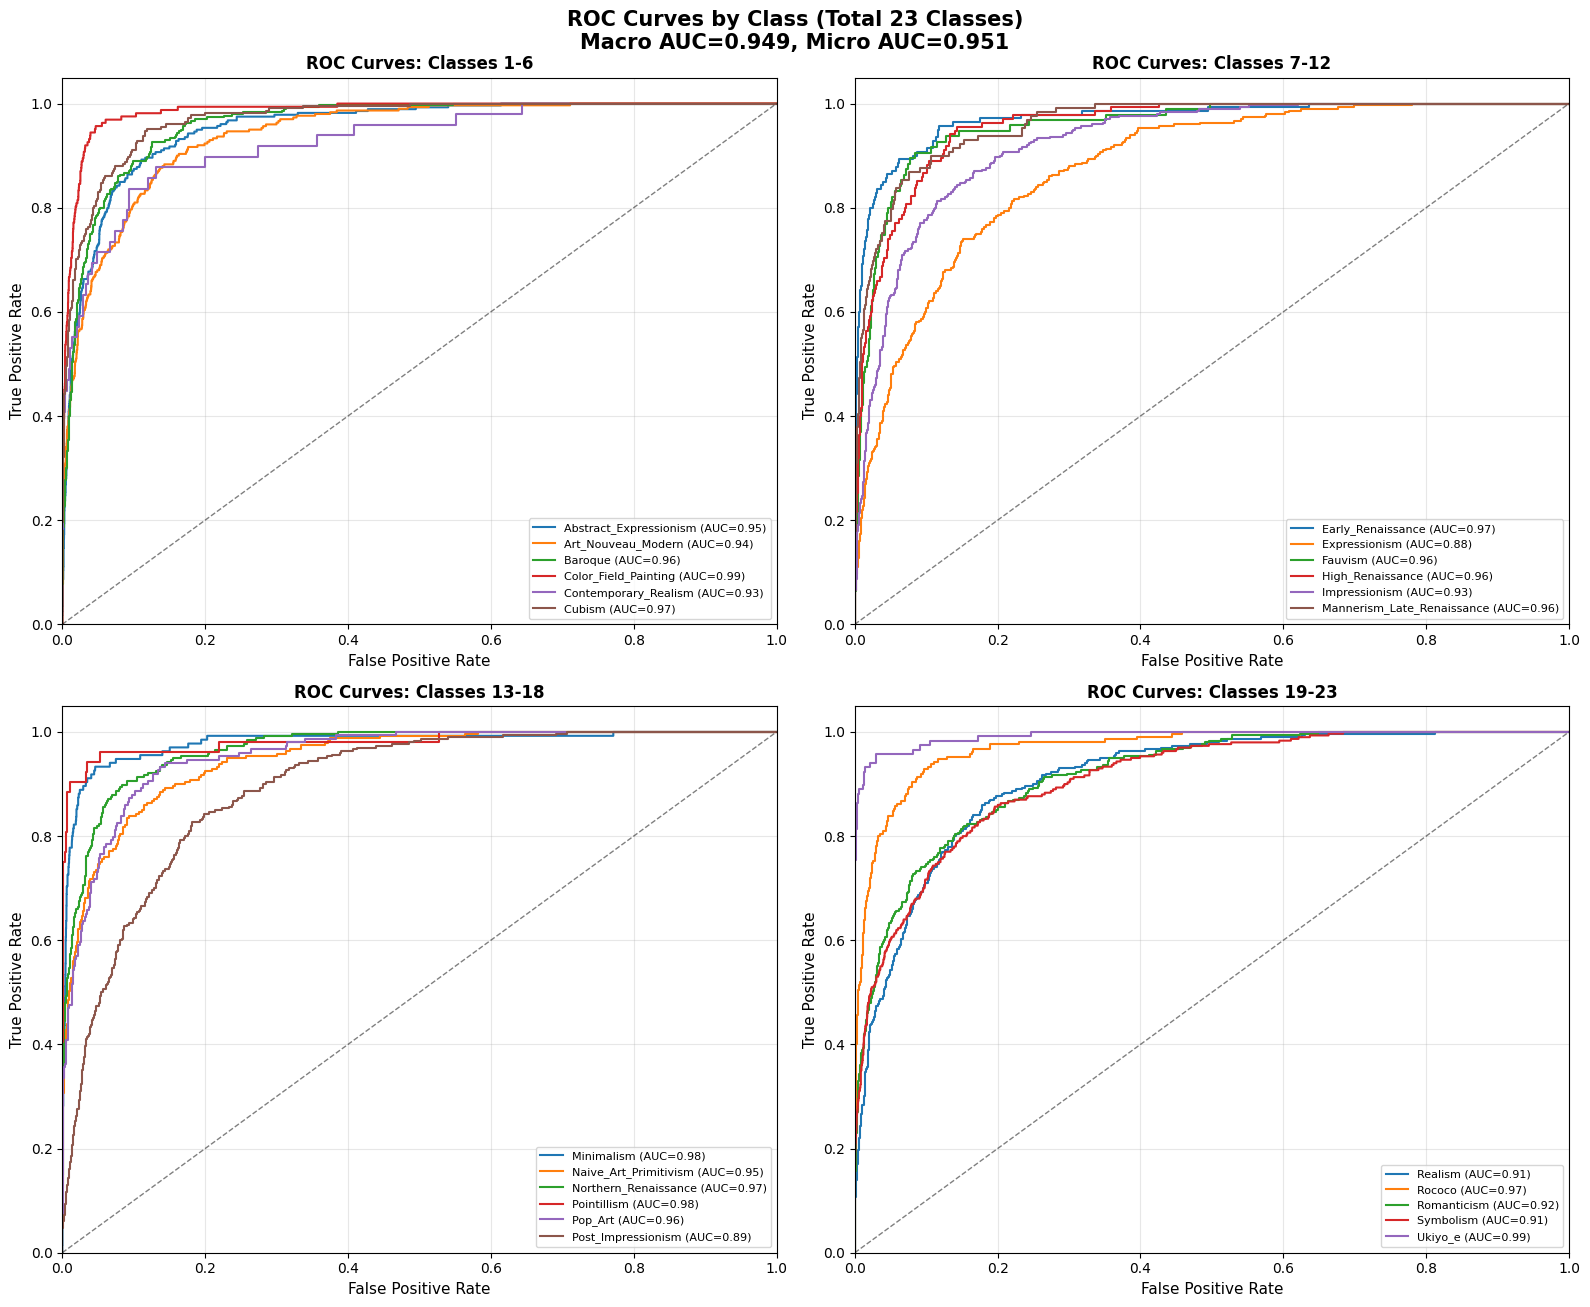


Per-Class AUC Summary (sorted):
Rank  Class                                  AUC
--------------------------------------------------
1     Ukiyo_e                              0.992
2     Color_Field_Painting                 0.986
3     Pointillism                          0.982
4     Minimalism                           0.980
5     Early_Renaissance                    0.972
6     Cubism                               0.970
7     Rococo                               0.970
8     Northern_Renaissance                 0.968
9     Mannerism_Late_Renaissance           0.963
10    Baroque                              0.961
11    High_Renaissance                     0.958
12    Fauvism                              0.958
13    Pop_Art                              0.956
14    Abstract_Expressionism               0.954
15    Naive_Art_Primitivism                0.948
16    Art_Nouveau_Modern                   0.942
17    Contemporary_Realism                 0.928
18    Impressionism               

In [ ]:

print("\n--- ROC Curve by Class (Split into 4 Panels) ---")


# Convert true labels to one-hot encoding
y_true_bin = label_binarize(all_labels, classes=range(len(class_names)))
n_classes = len(class_names)
y_score = all_predictions_probs  # softmax probabilities

# Compute ROC and AUC per class
fpr, tpr, roc_auc = {}, {}, {}
for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(y_true_bin[:, i], y_score[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Compute macro and micro averages
macro_auc = roc_auc_score(y_true_bin, y_score, average="macro", multi_class="ovr")
micro_auc = roc_auc_score(y_true_bin, y_score, average="micro", multi_class="ovr")

# --- Plot ROC curves in 4 grouped subplots ---
group_size = 6
num_groups = int(np.ceil(n_classes / group_size))

fig, axes = plt.subplots(2, 2, figsize=(16, 14))
axes = axes.flatten()

for g in range(num_groups):
    start = g * group_size
    end = min((g + 1) * group_size, n_classes)
    ax = axes[g]

    for i in range(start, end):
        ax.plot(fpr[i], tpr[i], lw=1.5,
                label=f'{class_names[i]} (AUC={roc_auc[i]:.2f})')

    ax.plot([0, 1], [0, 1], 'k--', lw=1, alpha=0.5)
    ax.set_xlim([0.0, 1.0])
    ax.set_ylim([0.0, 1.05])
    ax.set_title(f'ROC Curves: Classes {start+1}-{end}', fontsize=12, fontweight='bold')
    ax.set_xlabel('False Positive Rate', fontsize=11)
    ax.set_ylabel('True Positive Rate', fontsize=11)
    ax.legend(fontsize=8, loc='lower right')
    ax.grid(alpha=0.3)

# Handle extra subplots if fewer than 4 groups
for j in range(num_groups, len(axes)):
    fig.delaxes(axes[j])

fig.suptitle(f'ROC Curves by Class (Total {n_classes} Classes)\nMacro AUC={macro_auc:.3f}, Micro AUC={micro_auc:.3f}',
             fontsize=15, fontweight='bold', y=0.93)
plt.tight_layout(rect=[0, 0, 1, 0.95])
plt.savefig('/content/roc_curves_split_panels.png', dpi=150, bbox_inches='tight')
plt.show()

# --- Print Summary Table ---
roc_auc_sorted = sorted([(class_names[i], roc_auc[i]) for i in range(n_classes)],
                        key=lambda x: x[1], reverse=True)

print("\nPer-Class AUC Summary (sorted):")
print(f"{'Rank':<5} {'Class':<35} {'AUC':>6}")
print("-"*50)
for rank, (cls, auc_val) in enumerate(roc_auc_sorted, 1):
    print(f"{rank:<5} {cls:<35} {auc_val:>6.3f}")

print(f"\nMacro-average AUC: {macro_auc:.3f}")
print(f"Micro-average AUC: {micro_auc:.3f}")


With a ***macro-average AUC of 0.949*** and ***micro-average AUC of 0.951***, the model demonstrates strong overall discriminative performance across all 23 classes.

- ***Top-performing styles*** (AUC ≥ 0.97):
Ukiyo_e, Color_Field_Painting, Pointillism, Minimalism, Early_Renaissance, Cubism, Rococo —
these are visually distinctive styles with clear features (color tone, structure, or brushwork) that the model learns effectively.

- ***Moderate-performing styles*** (AUC ≈ 0.94–0.96):
Baroque, High_Renaissance, Pop_Art, Abstract_Expressionism, and others —
the model can still separate these reliably, though they share partial visual overlap with similar styles.

- ***Lower-performing styles*** (AUC < 0.92):
Romanticism, Realism, Symbolism, Post_Impressionism, Expressionism —
these styles exhibit more inter-class similarity and visual complexity, which makes them harder to differentiate.

High AUC values across most classes confirm that the fine-tuned EfficientNetB0 model has learned meaningful and generalizable visual features.
Even in visually overlapping categories, the ROC-based separability remains strong, showing the model’s reliability in multi-class art style classification.

# VIII. Final Conclusion

####What I learned from this project

- Implemented transfer learning in two stages: first training only the new classification head, then fine-tuning the last layers of EfficientNetB0.

- Understood the EfficientNetB0 architecture.
- Practiced dataset management — addressing imbalance by capping samples per class, splitting into train/val/test, and applying augmentation.

- Gained experience in model regularization, learning rate scheduling, and using callbacks (early stopping, checkpointing, reduce LR).

- Evaluated performance through different methods

####Future Improvements

- Focus on more visually distinct styles to better measure discriminative ability.

- For overlapping styles (e.g., Impressionism vs. Realism), include contextual metadata (painter, year, region) to aid classification.

- Experiment with larger EfficientNet variants (B2–B4) or Vision Transformers (ViT) for improved feature extraction.

- Apply class-balanced loss functions or focal loss to further mitigate imbalance.